In [1]:
# libraries and functions
import sys
sys.path.append("../../functions")
from import_auxiliary import import_data
from save_load import save_data_a0, load_data_a0
from analysis import metrics_computation, matrix_distance
from plot import metrics_plot

import numpy as np
from datetime import datetime
import os.path

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# path
path_CM_red = "../../data/compliant_matrix.json"
path_CM_yellow = "../../data/non_compliant_matrix.json"
path_Nij = "../../data/Nij.json"

# global variables
n_comp = 14                                                                                 # number of compartments
age_groups = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-59', '60+']                     # list of strings with age groups 
age_groups_bins = [0, 5, 18, 30, 40, 50, 60, np.inf]                                        # list of int with age groups extremes 
n_age = len(age_groups)                                                                     # number of age groups
n_sev = 5                                                                                   # number of perceived severity groups

In [2]:
# IMPORT AND PARAMETERS

# import data
Italy_dict = import_data(path_CM_red, path_CM_yellow, path_Nij)  

# parameters

t_step = 1                                                                  # temporal step (in days)
initial_date = datetime(2020, 2, 1)                                         # starting date of the simulation
end_date = datetime(2021, 4, 1)                                             # ending date of the simulation
t_max = int((end_date - initial_date).days * (1/t_step))                    # number of days in the simulation
start_vaccination = initial_date                                            # starting date of vaccination
tV0 = int((start_vaccination - initial_date).days * (1/t_step))             # days after which the vaccination starts

beta = 0.08                                                                 # attack rate
mu = 1 / 5                                                                  # inverse of infectious period
epsilon = 1 / 4                                                             # inverse of latent period
omega = 1 / 1.8                                                             # inverse of presymptomatic period
delta = 15                                                                  # n. of days to death after the transition I -> R
chi = 0.55                                                                  # reduced infectiousness of presymptomatics and asymptomatics

type_v = 'age'                                                              # vaccination strategy
r_v = 0.0025                                                                # rate of vaccination
VE_S = 0.7                                                                  # vaccine efficacy on susceptibles
VE_Symp = 0.5                                                               # vaccine efficacy on symptoms
VE_D = 0.4                                                                  # vaccine efficacy on severe oucomes

i0 = 550000 / np.sum(Italy_dict["Nij"])                                     # initial conditions: fraction of individuals in infected comaprtments
icu0 = 2500 / np.sum(Italy_dict["Nij"])                                     # initial conditions: fraction of individuals in ICU
r0 = 0.1                                                                    # initial conditions: fraction of recovered individuals
d0 = 0                                                                      # initial conditions: fraction of deaths
ICU_max = 7200                                                              # max number of ICU

# age stratified parameters

f = [0.397, 0.573, 0.476, 0.407, 0.329, 0.265, 0.152]                       # Fraction of asymptomatics                   

IFR = [1.61e-05, 6.95e-05, 0.000309, 0.000844, 0.00161, 0.00595, 0.0328]    # Infectious Fatality Ratio for 7 age groups

PIH = [0.001, 0.001, 0.005, 0.011, 0.014, 0.029, 0.058]                     # Probabiity of being hospitalised if infected      
PHICU = [0.222, 0.222, 0.116, 0.159, 0.222, 0.276, 0.308]                   # Probabiity of going to ICU if hospitalised        
IICUR = [a*b for a,b in zip(PIH,PHICU)]                                     # Probabiity of going to ICU if infected

PICUD = [0.0, 0.0, 0.022, 0.048, 0.048, 0.116, 0.209]                       # Probabiity of dying if in ICU                     

function_types = ['lin', 'centerlin', 'startendlin', 'startlin', 'endlin']

comps = ['S', '$S_{NC}$', 'V', '$V_{NC}$', 'L', 'P', 'I', '$L_V$', '$P_V$', '$I_V$', 'A', 'ICU', 'R', 'D']

In [3]:
# behavioral parameters
alpha = 10                                                                  # slope of C->NC transition
gamma = 5                                                                   # slope of NC->C transition
a0s = np.linspace(0.01, 1, num=30)                                          # array of midpoints of C->NC transition 
b0 = 0.75                                                                   # midpoint of NC->C transition
max_sigma = 0.3                                                             # maxium value of variance
grow = True                                                                 # True if variance refers to a0, False otherwise

# saving variables
folder = '../../runs/main/'
folder_fig = '../../output/main/'
string_save = f'3metrics_heatmap_a0dict_gamma{gamma}_b0{b0}_alpha{alpha}.pickle'
string_fig = f'Heatmap_a0_gamma{gamma}_b0{b0}_alpha{alpha}.pdf'

In [4]:
# Generate data for the three metrics or load exisiting data
if os.path.exists(folder + string_save):
    a0_dict, sigma_a0_dict, cases_dict, deaths_dict, peak_high_dict, peak_date_dict = load_data_a0(folder, alpha, gamma, b0)
else:
    a0_dict, sigma_a0_dict, cases_dict, deaths_dict, peak_high_dict, peak_date_dict = metrics_computation(Italy_dict, i0, icu0, r0, d0, initial_date, t_max, tV0, beta, epsilon, omega, mu, delta, chi, f, IFR, IICUR, PICUD, ICU_max, r_v, type_v, VE_S, VE_Symp, VE_D, [alpha]*5, [gamma]*5, a0s, [b0]*5, t_step, max_sigma, grow, function_types)
    save_data_a0(folder, alpha, gamma, b0, a0_dict, sigma_a0_dict, cases_dict, deaths_dict, peak_high_dict, peak_date_dict)

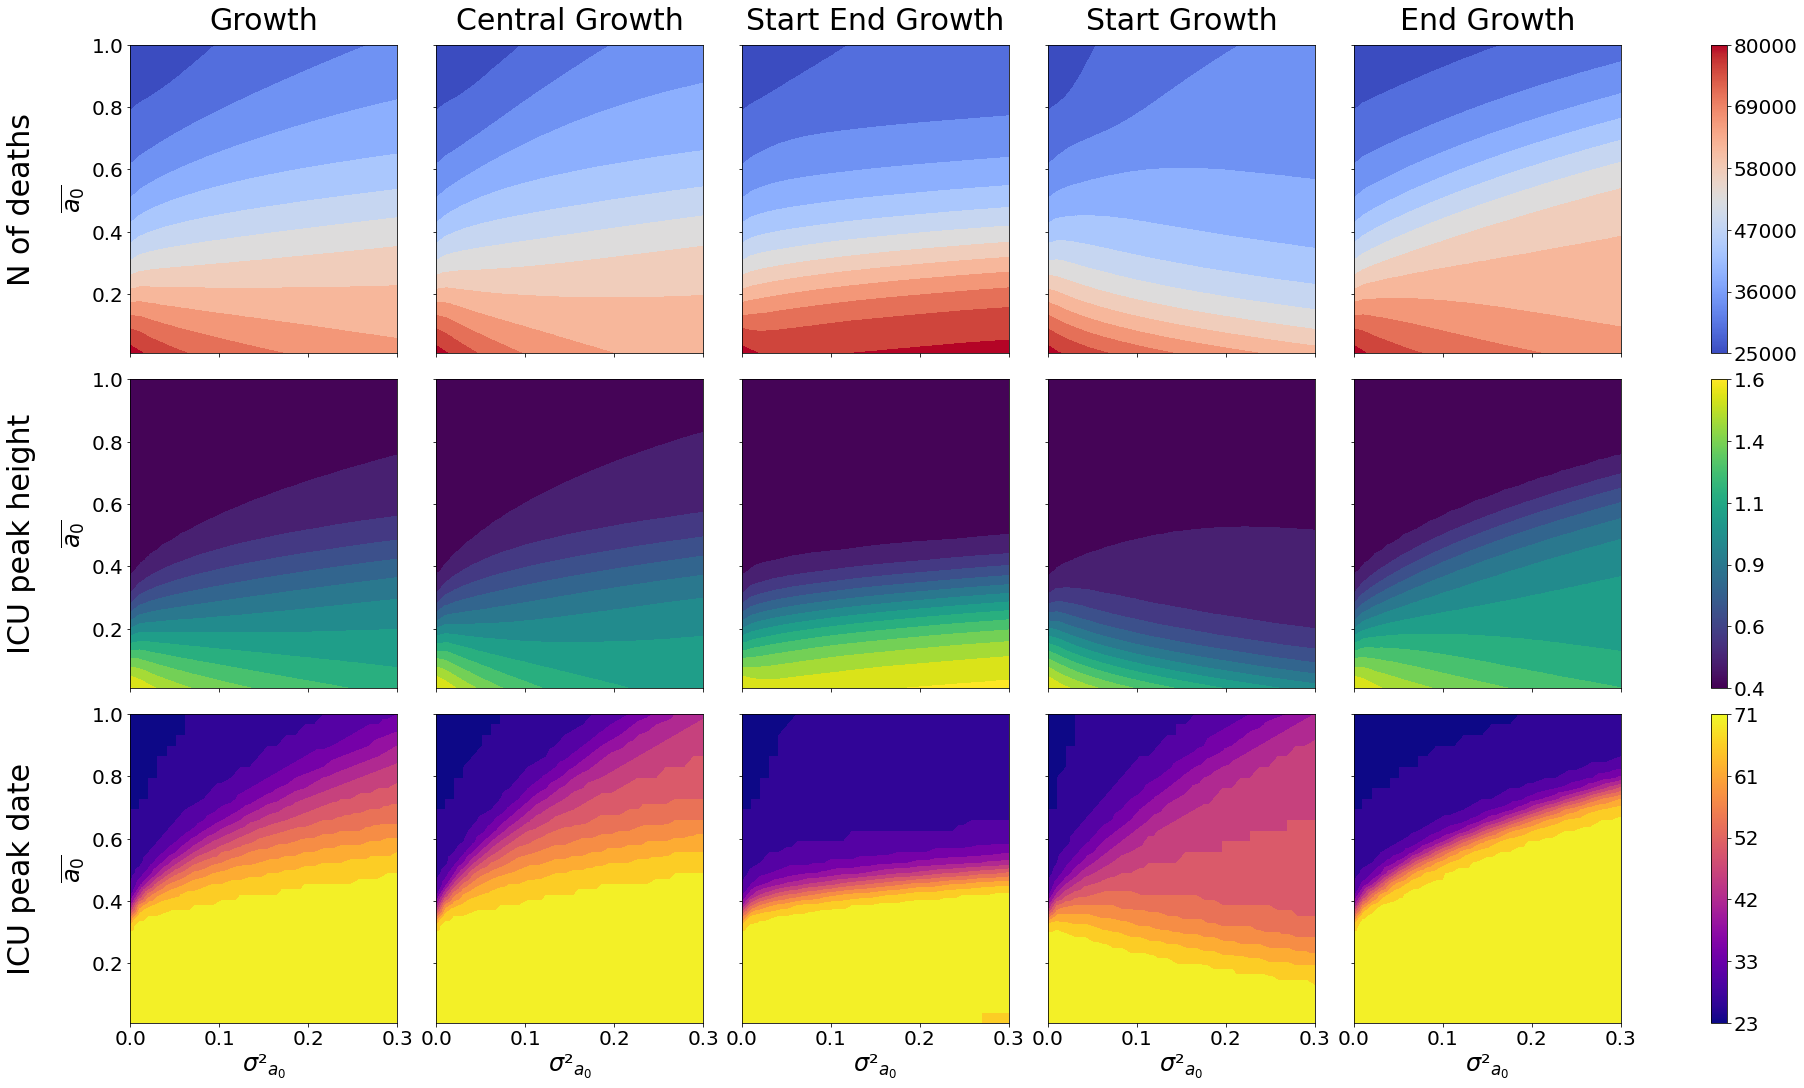

In [5]:
# Plot the three metrics for each of the five functions
metrics_plot(a0_dict, sigma_a0_dict, deaths_dict, peak_high_dict, peak_date_dict, grow, function_types, savefig = folder_fig + '3_metrics/3_metrics_5functions.png')

In [6]:
# compute normalised Canberra distance
matrix_distance(deaths_dict, peak_high_dict, peak_date_dict, function_types, contribution = False)

(                lin  centerlin  startendlin  startlin  endlin
 lin          0.0000     0.0084       0.0341    0.0411  0.0232
 centerlin    0.0084     0.0000       0.0423    0.0410  0.0293
 startendlin  0.0341     0.0423       0.0000    0.0564  0.0410
 startlin     0.0411     0.0410       0.0564    0.0000  0.0633
 endlin       0.0232     0.0293       0.0410    0.0633  0.0000,
                 lin  centerlin  startendlin  startlin  endlin
 lin          0.0000     0.0095       0.0413    0.0637  0.0330
 centerlin    0.0095     0.0000       0.0506    0.0615  0.0387
 startendlin  0.0413     0.0506       0.0000    0.0769  0.0569
 startlin     0.0637     0.0615       0.0769    0.0000  0.0956
 endlin       0.0330     0.0387       0.0569    0.0956  0.0000,
                 lin  centerlin  startendlin  startlin  endlin
 lin          0.0000     0.0210       0.0816    0.0519  0.0398
 centerlin    0.0210     0.0000       0.1016    0.0513  0.0562
 startendlin  0.0816     0.1016       0.0000    0.096

In [7]:
# compute maximum contribution to normalised Canberra distance
matrix_distance(deaths_dict, peak_high_dict, peak_date_dict, function_types, contribution = True)

(              lin  centerlin  startendlin  startlin  endlin
 lin          0.00       0.03         0.09      0.13    0.09
 centerlin    0.03       0.00         0.11      0.13    0.08
 startendlin  0.09       0.11         0.00      0.18    0.13
 startlin     0.13       0.13         0.18      0.00    0.18
 endlin       0.09       0.08         0.13      0.18    0.00,
               lin  centerlin  startendlin  startlin  endlin
 lin          0.00       0.04         0.14      0.25    0.15
 centerlin    0.04       0.00         0.17      0.25    0.15
 startendlin  0.14       0.17         0.00      0.33    0.26
 startlin     0.25       0.25         0.33      0.00    0.29
 endlin       0.15       0.15         0.26      0.29    0.00,
               lin  centerlin  startendlin  startlin  endlin
 lin          0.00       0.15         0.33      0.17    0.21
 centerlin    0.15       0.00         0.34      0.17    0.30
 startendlin  0.33       0.34         0.00      0.29    0.42
 startlin     0.17    